In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.datasets import make_classification
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot= True)
from random import shuffle

import glob

import os
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
def TRAIN_SIZE(num):
    print ('Total Training Images in Dataset = ' + str(mnist.train.images.shape))
    print ('--------------------------------------------------')
    x_train = mnist.train.images[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    y_train = mnist.train.labels[:num,:]
    print ('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train

In [3]:
x_train, y_train = TRAIN_SIZE(500)

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (500, 784)
y_train Examples Loaded = (500, 10)



In [4]:
def TEST_SIZE(num):
    print ('Total Test Examples in Dataset = ' + str(mnist.test.images.shape))
    print ('--------------------------------------------------')
    x_test = mnist.test.images[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    y_test = mnist.test.labels[:num,:]
    print ('y_test Examples Loaded = ' + str(y_test.shape))
    return x_test, y_test

In [5]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a,b

In [6]:
class MultiplyGate:
    def forward(self,W, X):
        
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

In [7]:
class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

In [8]:
class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

In [9]:
class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff

In [10]:
class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs

In [11]:
class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input1 = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input1)
            add = addGate.forward(mul, self.b[i])
            input1 = layer.forward(add)

        probs = softmaxOutput.predict(input1)
        print(probs)
        return np.argmax(probs, axis=1)

    def train(self, X, y, mini_batch_size=40, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        #costs=[]
        D = [0,0]
        S = [0,0]
        alpha = 0.999
        beta = 0.9

        
        plotx=[]
        ploty=[]
        for epoch in range(num_passes):
            # Forward propagation
            
            X,y=shuffle_in_unison(X,y)
            mini_X = [
                X[k:k+mini_batch_size]
                for k in range(0, len(y), mini_batch_size)]
            mini_y = [
                y[k:k+mini_batch_size]
                for k in range(0, len(y), mini_batch_size)]
            
            for ms in range(len(mini_y)):
                input = mini_X[ms]
                forward = [(None, None, input)]
                for i in range(len(self.W)):
                    mul = mulGate.forward(self.W[i], input)
                    add = addGate.forward(mul, self.b[i])
                    input = layer.forward(add)
                    forward.append((mul, add, input))

                # Back propagation
                dtanh = softmaxOutput.diff(forward[len(forward)-1][2], mini_y[ms])
                for i in range(len(forward)-1, 0, -1):
                    dadd = layer.backward(forward[i][1], dtanh)
                    db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                    dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                    S[i-1] = alpha*S[i-1] +(1-alpha)*np.square(dW)
                    D[i-1] = beta*D[i-1] +np.dot((1-beta),dW)
                    gt = (D[i-1]/(1-beta))*((1-alpha)/S[i-1])
            
                    # Add regularization terms (b1 and b2 don't have regularization terms)
                    dW += reg_lambda * self.W[i-1]+gt
                    # Gradient descent parameter update
                    self.b[i-1] += -epsilon * db
                    self.W[i-1] += -epsilon * dW

                if print_loss and epoch % 100 == 0:
                    plotx.append(epoch)
                    ploty.append( self.calculate_loss(X, y))
                if print_loss and epoch % 1000 == 0:
                    print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))
        return plotx,ploty

In [12]:
def normalize(X):
    mean = np.mean(X)
    std = (np.max(X) - np.min(X))
    X_new =(X-mean)/std
    return X_new

In [26]:
layers_dim = [784, 30, 10]
x_train,y_train = TRAIN_SIZE(500)
model = Model(layers_dim)
y = []
for elem in y_train:
    for j in range(len(elem)):
        if elem[j] == 1:
            y.append(j)
print(y)
x = normalize(x_train)
print(x_train[1])
px,py=model.train(x, y, mini_batch_size=50, num_passes=10000, epsilon=0.07, reg_lambda=0.005, print_loss=True)

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (500, 784)
y_train Examples Loaded = (500, 10)

[7, 3, 4, 6, 1, 8, 1, 0, 9, 8, 0, 3, 1, 2, 7, 0, 2, 9, 6, 0, 1, 6, 7, 1, 9, 7, 6, 5, 5, 8, 8, 3, 4, 4, 8, 7, 3, 6, 4, 6, 6, 3, 8, 8, 9, 9, 4, 4, 0, 7, 8, 1, 0, 0, 1, 8, 5, 7, 1, 7, 5, 5, 9, 9, 4, 2, 5, 3, 7, 4, 6, 6, 0, 1, 0, 1, 2, 4, 8, 5, 3, 5, 0, 0, 6, 4, 3, 8, 3, 7, 1, 4, 3, 9, 2, 2, 0, 3, 6, 6, 7, 4, 3, 2, 2, 4, 9, 1, 0, 5, 2, 4, 8, 2, 1, 0, 8, 4, 4, 8, 0, 6, 4, 1, 4, 9, 6, 3, 1, 2, 9, 0, 1, 0, 4, 2, 9, 9, 4, 3, 8, 6, 9, 3, 0, 6, 7, 0, 3, 1, 4, 2, 3, 3, 0, 4, 2, 5, 5, 6, 3, 7, 2, 8, 5, 9, 2, 0, 1, 1, 8, 2, 9, 3, 1, 4, 1, 5, 7, 6, 4, 7, 7, 8, 3, 9, 3, 0, 5, 1, 3, 2, 0, 3, 0, 4, 0, 7, 4, 8, 8, 9, 0, 0, 1, 8, 7, 3, 9, 9, 5, 5, 9, 6, 7, 8, 2, 4, 6, 9, 8, 1, 6, 7, 9, 1, 6, 2, 0, 9, 6, 6, 2, 9, 1, 1, 2, 1, 3, 1, 5, 2, 7, 8, 0, 1, 0, 2, 8, 0, 2, 7, 3, 7, 5, 5, 1, 8, 2, 2, 6, 9, 1, 8, 7, 4, 0, 6, 0, 7, 3, 1, 0, 6, 6, 0

Loss after iteration 1000: 1.480802
Loss after iteration 1000: 1.477601
Loss after iteration 1000: 1.477823
Loss after iteration 1000: 1.477593
Loss after iteration 1000: 1.490543
Loss after iteration 1000: 1.481892
Loss after iteration 1000: 1.481543
Loss after iteration 1000: 1.479087
Loss after iteration 1000: 1.481895
Loss after iteration 1000: 1.478504
Loss after iteration 2000: 1.411122
Loss after iteration 2000: 1.419779
Loss after iteration 2000: 1.416790
Loss after iteration 2000: 1.414143
Loss after iteration 2000: 1.413856
Loss after iteration 2000: 1.414512
Loss after iteration 2000: 1.414547
Loss after iteration 2000: 1.415124
Loss after iteration 2000: 1.412356
Loss after iteration 2000: 1.411796
Loss after iteration 3000: 1.390845
Loss after iteration 3000: 1.393498
Loss after iteration 3000: 1.393469
Loss after iteration 3000: 1.394740
Loss after iteration 3000: 1.391898
Loss after iteration 3000: 1.389773
Loss after iteration 3000: 1.393943
Loss after iteration 3000: 1

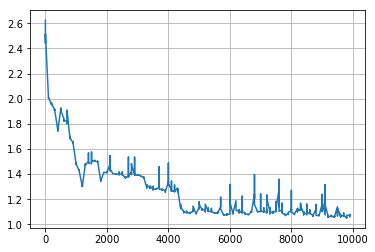

[[ 0.06342014  0.06342014  0.06342017 ...,  0.42916924  0.06342014
   0.06342014]
 [ 0.06163538  0.06095069  0.06181968 ...,  0.0610431   0.06095069
   0.06095069]
 [ 0.06078844  0.06105874  0.06078842 ...,  0.06463662  0.06078842
   0.06078842]
 ..., 
 [ 0.06073242  0.06069463  0.44074363 ...,  0.06069463  0.06069463
   0.06069463]
 [ 0.43786423  0.0593054   0.05930541 ...,  0.0593054   0.05949918
   0.0593054 ]
 [ 0.06095662  0.06095373  0.0620041  ...,  0.06096423  0.06095373
   0.06095373]]
[7, 3, 4, 6, 1, 8, 1, 0, 9, 8, 0, 3, 1, 2, 7, 0, 2, 9, 6, 0, 1, 6, 7, 1, 9, 7, 6, 5, 5, 8, 8, 3, 4, 4, 8, 7, 3, 6, 4, 6, 6, 3, 8, 8, 9, 9, 4, 4, 0, 7, 8, 1, 0, 0, 1, 8, 5, 7, 1, 7, 5, 5, 9, 9, 4, 2, 5, 3, 7, 4, 6, 6, 0, 1, 0, 1, 2, 4, 8, 5, 3, 5, 0, 0, 6, 4, 3, 8, 3, 7, 1, 4, 3, 9, 2, 2, 0, 3, 6, 6, 7, 4, 3, 2, 2, 4, 9, 1, 0, 5, 2, 4, 8, 2, 1, 0, 8, 4, 4, 8, 0, 6, 4, 1, 4, 9, 6, 3, 1, 2, 9, 0, 1, 0, 4, 2, 9, 9, 4, 3, 8, 6, 9, 3, 0, 6, 7, 0, 3, 1, 4, 2, 3, 3, 0, 4, 2, 5, 5, 6, 3, 7, 2, 8, 5, 9, 2

In [28]:
plt.plot(px,py)
plt.grid(True)
plt.show()
newy=model.predict(x)
print(y)
print(newy)
print(accuracy_score(y, newy))
print(confusion_matrix(y, newy))

In [38]:
x_test,y_test = TRAIN_SIZE(200)
y = []
for elem in y_test:
    for j in range(len(elem)):
        if elem[j] == 1:
            y.append(j)
print(y)
x = normalize(x_test)
testmodel=model.predict(x)
print(y)
print(testmodel)
print(accuracy_score(y,testmodel))
print(confusion_matrix(y, testmodel))

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (200, 784)
y_train Examples Loaded = (200, 10)

[7, 3, 4, 6, 1, 8, 1, 0, 9, 8, 0, 3, 1, 2, 7, 0, 2, 9, 6, 0, 1, 6, 7, 1, 9, 7, 6, 5, 5, 8, 8, 3, 4, 4, 8, 7, 3, 6, 4, 6, 6, 3, 8, 8, 9, 9, 4, 4, 0, 7, 8, 1, 0, 0, 1, 8, 5, 7, 1, 7, 5, 5, 9, 9, 4, 2, 5, 3, 7, 4, 6, 6, 0, 1, 0, 1, 2, 4, 8, 5, 3, 5, 0, 0, 6, 4, 3, 8, 3, 7, 1, 4, 3, 9, 2, 2, 0, 3, 6, 6, 7, 4, 3, 2, 2, 4, 9, 1, 0, 5, 2, 4, 8, 2, 1, 0, 8, 4, 4, 8, 0, 6, 4, 1, 4, 9, 6, 3, 1, 2, 9, 0, 1, 0, 4, 2, 9, 9, 4, 3, 8, 6, 9, 3, 0, 6, 7, 0, 3, 1, 4, 2, 3, 3, 0, 4, 2, 5, 5, 6, 3, 7, 2, 8, 5, 9, 2, 0, 1, 1, 8, 2, 9, 3, 1, 4, 1, 5, 7, 6, 4, 7, 7, 8, 3, 9, 3, 0, 5, 1, 3, 2, 0, 3, 0, 4, 0, 7, 4, 8]
[[ 0.06342014  0.06342014  0.06342017 ...,  0.42916924  0.06342014
   0.06342014]
 [ 0.06163755  0.06095056  0.06181687 ...,  0.06104347  0.06095056
   0.06095056]
 [ 0.06078832  0.06105847  0.06078831 ...,  0.06463884  0.0607